Import necessay libraries

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
#from kerastuner import HyperModel
from tensorflow import keras

Set seed for numpy and tensorflow

In [53]:
np.random.seed(42)
tf.random.set_seed(42)

Seclare global arrays to hold training/validation/testing datasets

In [54]:
global train_images
global train_labels
global validation_images
global validation_labels
global test_images
global test_labels

Load the dataset

In [55]:
train_images = np.load('.\\dataset\\train_images_singleImages.npy')
train_labels = np.load('.\\dataset\\train_labels_singleImages.npy')
test_images = np.load('.\\dataset\\test_images_singleImages.npy')
test_labels = np.load('.\\dataset\\test_labels_singleImages.npy')
 


In [56]:
# Helper function for visualizing test images
def plotTestImages(n):
    _, axes = plt.subplots(nrows=1, ncols = 10, figsize=(16,4))
    for ax, image, label in zip(axes, test_images[0:n], test_labels):
        ax.set_axis_off()
        ax.imshow(image, cmap='gray')        
        ax.set_title("Test: %i" % label)

Helper function for visualizing training images

In [57]:
def plotTrainImages(n):
    _, axes = plt.subplots(nrows=1, ncols = 10, figsize=(16,4))
    for ax, image, label in zip(axes, train_images[0:n], train_labels):
        ax.set_axis_off()
        ax.imshow(image, cmap='gray')        
        ax.set_title("Train: %i" % label)

In [58]:
def plotImages(images, imagelabels, indexes, name):
    selected_images = [images[i] for i in indexes]
    selected_labels = [imagelabels[i] for i in indexes]
    ncols = 10
    if len(images) < 10 :
        ncols = len(images)
    _, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(16,4))
    for ax, image, label in zip(axes, selected_images, selected_labels):
        ax.set_axis_off()
        ax.imshow(image, cmap='gray')        
        ax.set_title(f"{name} label {label}")

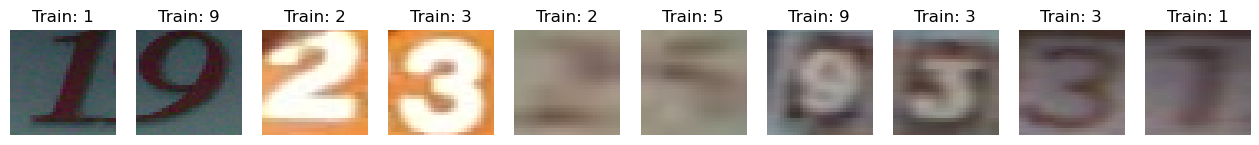

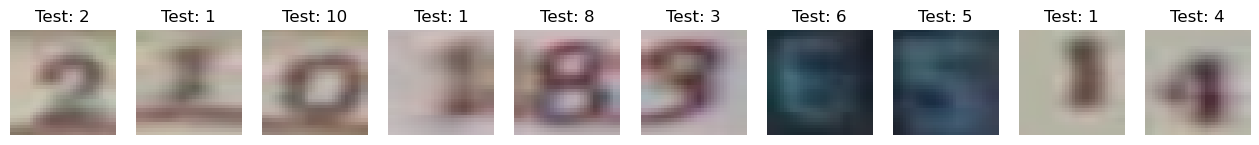

In [59]:
     
# Visualize train and test images
plotTrainImages(10)
plotTestImages(10)

In [60]:
print(train_images.shape)
print(train_labels.shape)
print(test_labels.shape)
print(test_images.shape)

(68095, 32, 32, 3)
(68095,)
(23542,)
(23542, 32, 32, 3)


Function to calculates the sharpness of an image using the variance of the Laplacian method.

In [61]:
def calculate_color_image_sharpness(image):  
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  
    # Apply Laplacian operator in the spatial domain
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)    
    # Calculate and return the variance
    return np.var(laplacian)

Function to remove blurry images in the dataset

In [62]:
def find_blurry_color_images():
    global train_images
    global train_labels
    global validation_images
    global validation_labels
    global test_images
    global test_labels
    
    # Check blurry images in the training dataset
    sharpness_scores = [calculate_color_image_sharpness(image) for image in train_images]
    threshold = np.percentile(sharpness_scores, 15)  #using the 20th percentile as threshold
    # Filter indices of non-blurry images
    non_blurry_indices = [i for i, score in enumerate(sharpness_scores) if score >= threshold]
    
    # Use the indices to filter your images and labels
    train_images = train_images[non_blurry_indices]
    train_labels = train_labels[non_blurry_indices]      
    print(f"TRAINING image threshold = {threshold:.2f}")    
        
    # Check blurry images in testing dataset
    sharpness_scores = [calculate_color_image_sharpness(image) for image in test_images]
    threshold = np.percentile(sharpness_scores, 15)  # using the 20th percentile as threshold   
    
    # Filter indices of non-blurry images
    non_blurry_indices = [i for i, score in enumerate(sharpness_scores) if score >= threshold]
    
    blurry_indexes = [i for i in range(len(test_images))   if i not in non_blurry_indices]
    
    plotImages(test_images, test_labels, blurry_indexes, "test")
        
    # Use the indices to filter your images and labels
    test_images = test_images[non_blurry_indices]
    test_labels = test_labels[non_blurry_indices]             
    print(f"TESTING image threshold = {threshold:.2f}")
   

In [63]:
# Function to preprocess the traing and testing images 
def preprocessImages():
    global train_images
    global train_labels
    global test_images
    global test_labels
    sharpness_threshold = 0.015 
    
    find_blurry_color_images()    
    
    train_labels = np.where(train_labels==10, 0, train_labels)
    test_labels = np.where(test_labels==10, 0, test_labels)

    # Normalize the images.
    train_images = train_images / 255.0
    test_images = test_images / 255.0
       
    
    ##############################################
    num_labels = 10
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # Adjust layout as needed

    for label in range(num_labels):
        # Find indexes of all images with the current label
        indexes = np.where(train_labels == label)[0]
        
        # Select images with the current label
        label_images = train_images[indexes]
        
        # Calculate the mean pixel value across all images of this label
        mean_pixels = np.mean(label_images, axis=0)
           
        # Calculate the overall mean across all pixels and color channels for simplification
        print(f"label = {label} : overall_mean_pixels = {np.mean(mean_pixels, axis=(0, 1, 2))}, overall_std_pixels = {np.std(mean_pixels, axis=(0, 1, 2))}")
  
        # Calculate the average across the RGB channels
        grayscale_image = np.mean(mean_pixels, axis=-1, keepdims=True)
        
        # Plot histogram of these mean pixel values
        ax = axs[label // 5, label % 5]  # Adjust for your layout
        ax.hist(grayscale_image.flatten(), bins=50, alpha=0.6)
        ax.set_title(f'Label {label}')
        ax.set_xlabel('Mean')
        ax.set_ylabel('Frequency')


    # # Apply the threshold to conver to black and white image
    # for i, image in enumerate(train_images):
    #     th = np.mean(image)
    #     _, train_images[i] = cv2.threshold(image, th, 1, cv2.THRESH_BINARY)
        
    # # Apply the threshold to conver to black and white image
    # for i, image in enumerate(test_images):
    #     th = np.mean(image)
    #     _, test_images[i] = cv2.threshold(image, th, 1, cv2.THRESH_BINARY)
        
    plt.tight_layout()
    plt.show()

    # ################################



    # One-hot encode the labels
    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)
    

In [64]:
print(f"Before preProcessing: train_image shape: {train_images.shape}")
print(f"Before preProcessing: train_labels shape: {train_labels.shape}")
print(f"Before preProcessing: test_labels shape: {test_labels.shape}")
print(f"Before preProcessing: test_images shape: {test_images.shape}")

Before preProcessing: train_image shape: (68095, 32, 32, 3)
Before preProcessing: train_labels shape: (68095,)
Before preProcessing: test_labels shape: (23542,)
Before preProcessing: test_images shape: (23542, 32, 32, 3)


TRAINING image threshold = 19.02
TESTING image threshold = 18.95
label = 0 : overall_mean_pixels = 0.4592442535152505, overall_std_pixels = 0.02030571496162353
label = 1 : overall_mean_pixels = 0.4572698597189943, overall_std_pixels = 0.021791745894734902
label = 2 : overall_mean_pixels = 0.4613703726136387, overall_std_pixels = 0.02048176505738654
label = 3 : overall_mean_pixels = 0.4530525581734634, overall_std_pixels = 0.021714245912425777
label = 4 : overall_mean_pixels = 0.4564748979012911, overall_std_pixels = 0.022661290184315612
label = 5 : overall_mean_pixels = 0.4490532551578587, overall_std_pixels = 0.020829042841576325
label = 6 : overall_mean_pixels = 0.4556290461894475, overall_std_pixels = 0.020588912728013747
label = 7 : overall_mean_pixels = 0.449437583306389, overall_std_pixels = 0.021772044982155882
label = 8 : overall_mean_pixels = 0.4533789385610751, overall_std_pixels = 0.02054009040955996
label = 9 : overall_mean_pixels = 0.44954254965875284, overall_std_pixels =

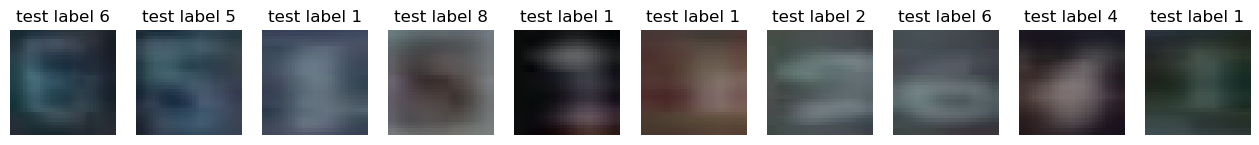

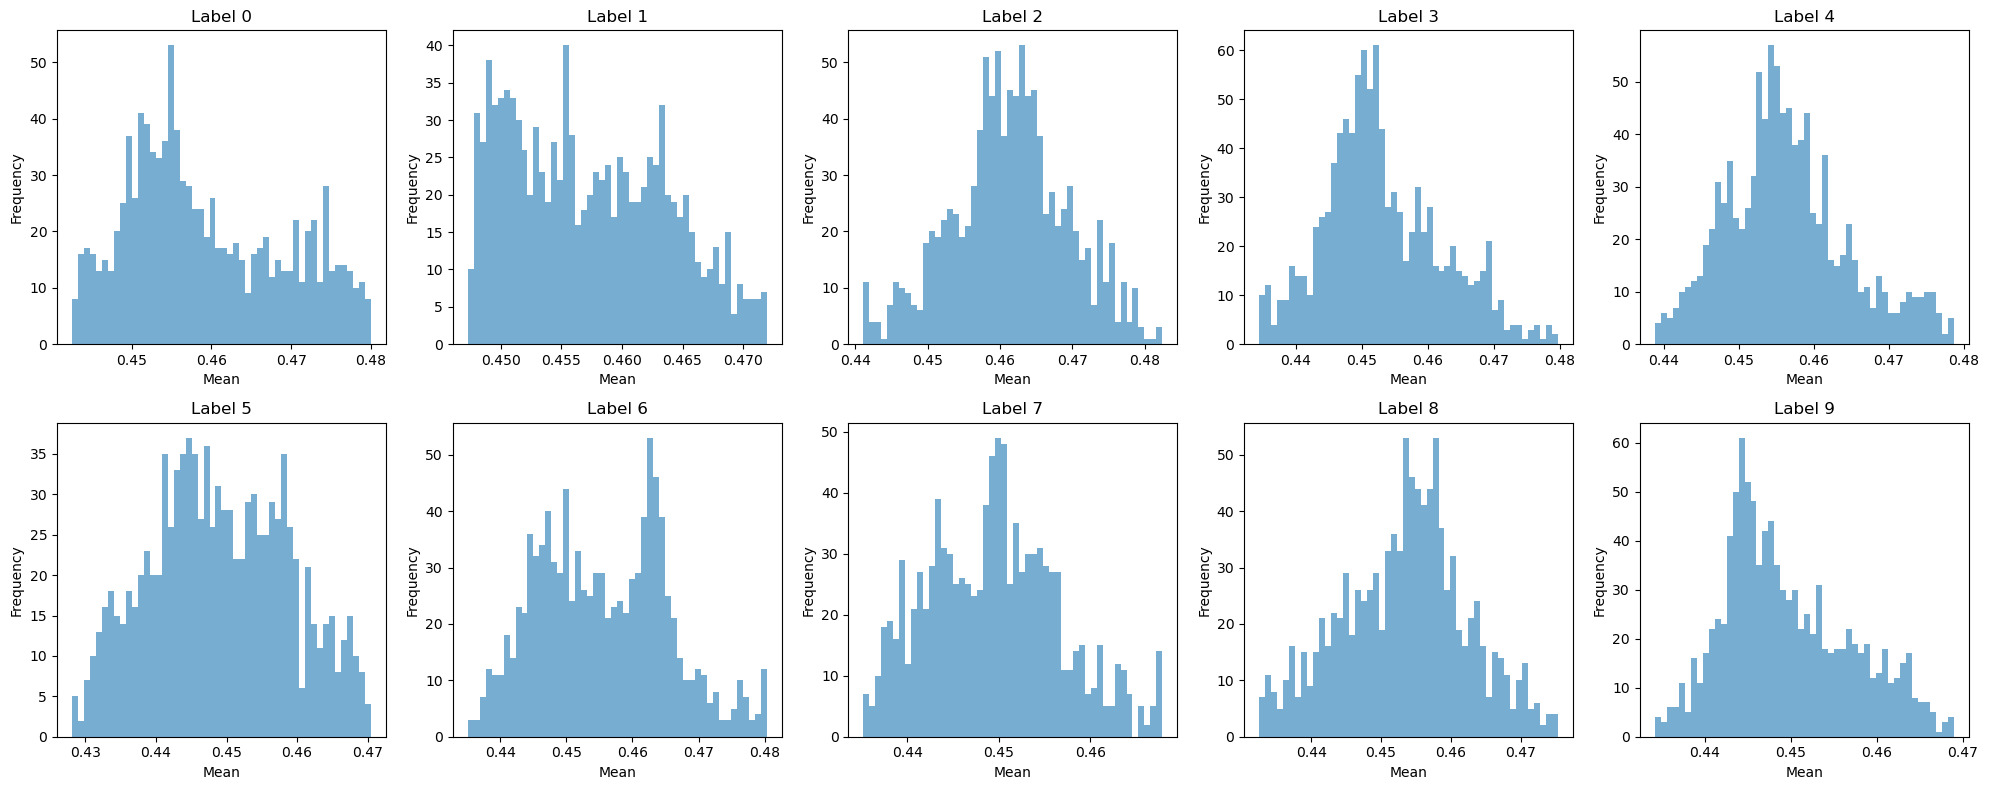

In [65]:
preprocessImages()

In [66]:
print(f"After preProcessing: train_image shape: {train_images.shape}")
print(f"After preProcessing: train_labels shape: {train_labels.shape}")
print(f"After preProcessing: test_labels shape: {test_labels.shape}")
print(f"After preProcessing: test_images shape: {test_images.shape}")

After preProcessing: train_image shape: (57880, 32, 32, 3)
After preProcessing: train_labels shape: (57880, 10)
After preProcessing: test_labels shape: (20010, 10)
After preProcessing: test_images shape: (20010, 32, 32, 3)


Split training data and labels into training and validation set

In [67]:
train_images_split, validation_images, train_labels_split, validation_labels = train_test_split(train_images, train_labels, test_size=0.25, random_state=42)

In [68]:
print(f"After train/validation split train_images shape: {train_images_split.shape}")
print(f"After train/validation split train_labels shape: {train_labels_split.shape}")
print(f"After train/validation split validation_images shape: {validation_images.shape}")
print(f"After train/validation split validation_labels shape: {validation_labels.shape}")

After train/validation split train_images shape: (43410, 32, 32, 3)
After train/validation split train_labels shape: (43410, 10)
After train/validation split validation_images shape: (14470, 32, 32, 3)
After train/validation split validation_labels shape: (14470, 10)


Callback for early stopping

In [69]:
early_stopping = EarlyStopping(monitor='val_loss', 
                                min_delta=0.001, 
                                patience=5, 
                                verbose=1, 
                                mode='min', 
                                restore_best_weights=True)

NN Model 

In [70]:
model = Sequential([
    # First Convolutional Block
    Conv2D(32, kernel_size=(3,3),activation='relu', input_shape=(32, 32, 3)),
    BatchNormalization(),
    # MaxPooling2D(2, 2),
    Dropout(rate = 0.2),

    # Second Convolutional Block
    Conv2D(64, kernel_size=(5,5),activation='relu'),
    BatchNormalization(),
    # MaxPooling2D(2,2),
    Dropout(rate = 0.4),


    # Third Convolutional Block
    Conv2D(128, kernel_size=(5,5), activation='relu'),
    BatchNormalization(),
    # MaxPooling2D(2,2),
    Dropout(rate = 0.4),

    # Classifier Head
    Flatten(),
    Dense(units=256, activation='relu'),
    BatchNormalization(),
    Dropout(rate = 0.5),

    Dense(10, activation='softmax')
])

In [71]:
from tensorflow.keras.optimizers import Adam
# Create an instance of the Adam optimizer with desired learning rate
optimizer_lr = Adam(learning_rate=0.000135)

In [72]:
model.compile(optimizer=optimizer_lr, loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/10
1357/1357 [==============================] - 118s 86ms/step - loss: 1.0383 - accuracy: 0.6987 - val_loss: 0.4487 - val_accuracy: 0.8695
Epoch 2/10
1357/1357 [==============================] - 118s 87ms/step - loss: 0.5141 - accuracy: 0.8471 - val_loss: 0.3662 - val_accuracy: 0.8908
Epoch 3/10
1357/1357 [==============================] - 132s 97ms/step - loss: 0.4076 - accuracy: 0.8772 - val_loss: 0.3240 - val_accuracy: 0.9069
Epoch 4/10
1357/1357 [==============================] - 117s 86ms/step - loss: 0.3515 - accuracy: 0.8951 - val_loss: 0.3087 - val_accuracy: 0.9114
Epoch 5/10
1357/1357 [==============================] - 118s 87ms/step - loss: 0.3117 - accuracy: 0.9063 - val_loss: 0.2843 - val_accuracy: 0.9198
Epoch 6/10
1357/1357 [==============================] - 117s 86ms/step - loss: 0.2785 - accuracy: 0.9165 - val_loss: 0.2847 - val_accuracy: 0.9183
Epoch 7/10
1357/1357 [==============================] - 118s 87ms/step - loss: 0.2462 - accuracy: 0.9251 - val_loss: 0

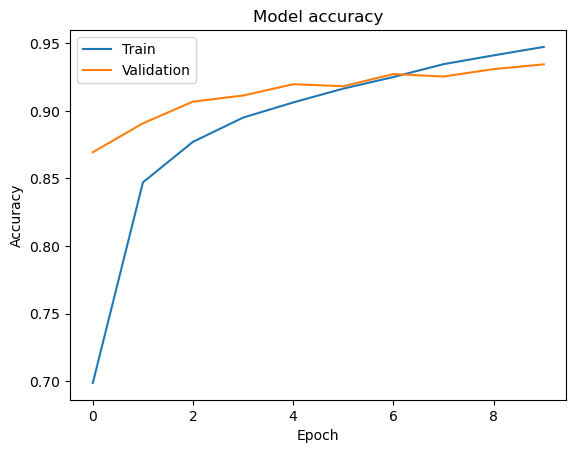

In [73]:
history = model.fit(train_images_split, train_labels_split, epochs=10, validation_data=(validation_images, validation_labels), batch_size=32, callbacks=[early_stopping])
history = model.history
# Plot training & validation accuracy values
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

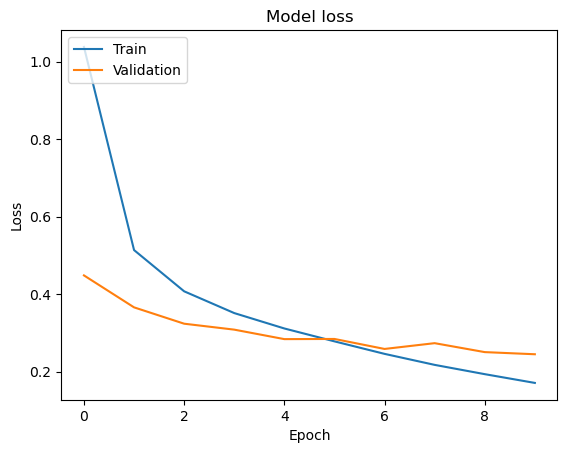

In [74]:
plt.figure()
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [75]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

626/626 - 11s - loss: 0.3306 - accuracy: 0.9062 - 11s/epoch - 17ms/step

Test accuracy: 0.9061968922615051


In [76]:
predictions = model.predict(test_images)
model.save('svhn_hyper_par_tuned_model.h5')

626/626 [==============================] - 11s 17ms/step


C:\Users\bplse\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [77]:
################### CNN ################################################